# The Dynamic Factor Model


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import metran

<div class="alert alert-block alert-info">
<b>Tip:</b> To run this notebook, it is strongly recommended to install Numba (http://numba.pydata.org). This Just-In-Time (JIT) compiler compiles the computationally intensive part of the calculations which leads to significantly faster performance.
</div>

When modeling multiple groundwater time series within the same hydrological system, it often appears that these components show distinct correlations between locations. Usually large part of the correlation is caused by common input stresses like precipitation and evapotranspiration, which shows up within the deterministic components of the models.

The residual components of the univariate TFN models are often correlated as well. This means that there is spatial correlation
which has not been captured by the deterministic component, e.g. because of errors in common input data or due to simplification of the hydrological model leading to misspecification of the deterministic component. We can exploit these correlations by modeling the series simultaneously with a dynamic factor model. Dynamic factor modeling (DFM) is a multivariate timeseries analysis technique used to describe the variation among many variables in terms of a few underlying but unobserved variables called factors.

This notebook explains the Dynamic Factor Model (DFM) as presented in [Berendrecht and Van Geer, 2016](#References). It describes the model, model parameters and how the results may be interpreted.

## 1. Basic multivariate AR(1) model
A general univariate AR(1) model can be written as:

$$ 
\begin{align}
 {x}_t&=\phi x_{t-1}+\eta_t\\
 {n}_t&={x}_t+\varepsilon_t
\end{align}
$$

with $\phi$ the AR(1) parameter, $\eta_t$ a zero mean white noise process, and $\varepsilon_t$ the measurement noise. In the current version of `metran` the measurement noise is assumed to be zero, so that $n_t=x_t$.

The multivariate extension of this model is:

$$ 
 \left[\begin{array}{c}x_{1}\\x_{2}\end{array}\right]_t = \left[\begin{array}{cc}\phi_{1} & 0\\0 & \phi_{2}\end{array}\right] \left[\begin{array}{c}x_{1}\\x_{2}\end{array}\right]_{t-1} + \left[\begin{array}{c}\eta_{1}\\\eta_{2}\end{array}\right]_t
$$

Or:

$$ 
 \mathbf{x}_t=\mathbf{\Phi} \mathbf{x}_{t-1}+\mathbf{\eta}_t
$$

## 2. Generate synthetic correlated time series
Let us generate time series based on the 2-dimensional model given above. We use the AR(1) model to generate two time series with the AR(1) parameter $\phi$. Furthermore, we define the desired correlation between these series.

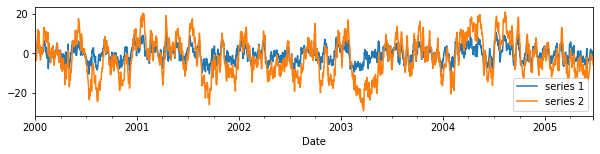

In [4]:
# Set AR(1) parameters
phi = np.array([0.85, 0.95])

# Desired correlation of AR(1) processes
corr = 0.8

# Set the parameters for the noise series
mean = [0, 0]
var = np.array([4, 9])
stds =  np.sqrt(var/(1-phi**2))
rho = stds[0]*stds[1]*corr*(1-phi[0]*phi[1])

# Calculate covariance
cov = [[var[0], rho],
        [rho, var[1]]]

# Generate noise series
noise = np.random.multivariate_normal(mean, cov, 2000)

# From the noise, generate AR(1) processes
a = np.zeros_like(noise)
for i in range(1, noise.shape[0]):
    a[i] = noise[i] + np.multiply(a[i - 1], phi)
s = pd.DataFrame(data=a, index=pd.date_range(start='1-1-2000', periods=2000), columns=['series 1', 'series 2'])

s.plot(figsize=(10,2), xlabel='Date');


We can calculated the mean and standard deviation of the generated series and test the correlation between these series. The correlation must be close to the desired correlation defined above.

In [5]:
print ('Mean:')
print (s.mean())
print ('\nStandard deviation:')
print (s.std())
print ('\nCorrelation:')
print (s.corr())

Mean:
series 1   -0.267595
series 2   -2.022714
dtype: float64

Standard deviation:
series 1    3.862808
series 2    9.267211
dtype: float64

Correlation:
          series 1  series 2
series 1  1.000000  0.821284
series 2  0.821284  1.000000


## 3. The Dynamic Factor Model
With the Dynamic Factor Model (DFM) we try to decompose series into latent (unobserved) factors describing common and specific dynamics. For the example above, the common dynamic factor describe the all variation that is found in both series. The remaining part of each series is described by the specific dynamic factor.

Mathematically, this can be written as:

$$ 
 \left[\begin{array}{c}n_{1,t}\\n_{2,t}\end{array}\right] = \left[\begin{array}{c}x_{s,1}\\x_{s,2}\end{array}\right]_t + \left[\begin{array}{c}\gamma_{1}\\ \gamma_{2}\end{array}\right] x_{c,t}
$$

where $\gamma_1$ and $\gamma_2$ are the factor loadings for series 1 resp. series 2. These factor loadings describe how the series $n_1$ and $n_2$ are related to the common dynamic factor.

The specific dynamic factors $x_s$ and common dynamic factor $x_c$ can be described by an AR(1) model as:

$$
\begin{align}
\mathbf{x}_{s,t}&=\left[\begin{array}{cc}\phi_{s,1} & 0\\0 & \phi_{s,2}\end{array}\right]\mathbf{x}_{s,t-1}+\left[\begin{array}{c}\eta_{s,1}\\\eta_{s,2}\end{array}\right]_t\\
x_{c,t}&=\phi_c x_{c,t-1}+\eta_{c,t}
\end{align}
$$

When analyzing more than two series, multiple common dynamic factors may be used. In that case, the equation for the common dynamic factor also becomes a vector equation.

## 4. Standardization<a id="standardization"></a>
With the DFM we want to describe the common and specifc dynamics based on the correlation  rather than the covariance structure. Therefore, all series are standardized as:

$$\tilde{n}_{i,t} = \frac{n_{i,t}-\mu_{n_i}}{\sigma_{n_i}}$$

This standardization is done internally in `metran`, so there is no need to perform any standardization beforehand. However, as an illustration, the code below shows the standardized series.

<AxesSubplot:xlabel='Date'>

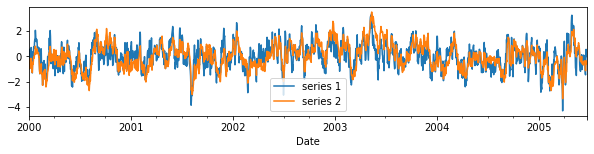

In [3]:
mt = metran.Metran(s)
series_std = mt.standardize(s)
series_std.plot(figsize=(10,2), xlabel='Date')

## 5. Factor loadings, communality and specificity<a id="factors"></a>
The factor loadings are an essential part of the Dynamic Factor Model. They describe the correlation between the variables and the common factors. In essence, the correlation matrix of $\tilde{\mathbf{n}}_t$, $\mathbf{\Sigma}$, is approximated by the product of the factor matrix $\mathbf{\Gamma}$ (in this example $\left[\begin{array}{c}\gamma_{1}\\ \gamma_{2}\end{array}\right]$) and its transpose, plus a diagonal matrix of uniqueness $\mathbf{\Psi}=\text{var}(\mathbf{x}_s)$ describing the unique or specific variance of the normalized residuals:

$$
\mathbf{\Sigma}=\mathbf{\Gamma}\mathbf{\Gamma}'+\mathbf{\Psi} \label{factorcorrelation}
$$

The variance which is shared by variables, $\mathbf{\Gamma}\mathbf{\Gamma}'$, is referred to as communality. The variance that is unique to each variable, $\mathbf{\Psi}$, is referred to as specificity.


## 6. Running the model
Let us now run the model for the generated time series. In this example, we solve the model with `report=False`. This means that no report is shown. Instead, we analyze the results step by step.

In [8]:
mt = metran.Metran(s)
mt.solve(report=False)
print ('factors' = mt.factors)

INFO: Number of factors according to Velicer's MAP test: 0
INFO: Number of factors according to Kaiser criterion: 1


[[0.89897661]
 [0.89897661]]


Metran first determines the optimal number of common dynamic factors based on the correlation structure of the time series. For this, the Minimum Average Partial (MAP) test is used ([Velicer, 1976](#References); [Velicer et al., 2000](#References)). If this test results in 0 factors, then a second test is done based on the Kaiser criterion ([Kaiser, 1960](#References)).

Besides, Metran estimates the factor loadings $\gamma_1$ and $\gamma_2$ using the minimum residual (minres) algorithm ([Harman and Jones, 1966](#References)).

After the number of factors and associated factor loadings have been estimated, Metran uses an optimization algorithm to estimate the AR(1) model parameters $\phi_{s,1}$, $\phi_{s,2}$, and $\phi_{c}$. Similar to the AR parameter is `pastas`, $\phi$ is written as:

$$
\phi_k=e^{−\Delta t_i/\alpha_k}
$$
and $\alpha_k$ is being estimated. The result is shown in `fit_report()`.

In [11]:
print (mt.fit_report())

Fit report Cluster          Fit Statistics
tmin     None             obj     1921.45
tmax     None             nfev    124
freq     D                AIC     1927.45
solver   ScipySolve               

Parameters (3 were optimized)
               optimal   stderr initial  vary
sdf1_alpha    4.477927   ±2.21%      10  True
sdf2_alpha  319.978612  ±17.85%      10  True
cdf1_alpha   13.455753   ±4.90%      10  True

Parameter correlations |rho| > 0.5
None


Further output of the Metran model parameters and statistics is given by `metran_report()`. The following results are shown:
- nfct: number of factors
- fep: percentage of total variance explained by factors
- communality for each series: see definition in [section 5](#factors)
- state parameters:
  - AR(1) parameter $\phi$
  - variance $q$ of white noise process $\eta$
- observation parameters:
  - factor loadings $\gamma$ for each factor and series
  - scale: standard deviation $\sigma_n$ of each series (used for standardization, see [section 4](#standardization))
  - mean: mean $\mu_n$ of each series (used for standardization, see [section 4](#standardization))
- state correlations: correlation between specific and/or common dynamic factors

In [12]:
print (mt.metran_report())

Metran report Cluster        Factor Analysis
tmin     None                nfct    1
tmax     None                fep     89.97%
freq     D                            

Communality
                
series 1  80.82%
series 2  80.82%

State parameters
               phi         q
sdf1      0.799861  0.069106
sdf2      0.996880  0.001195
cdf1      0.928377  0.138117

Observation parameters
            gamma1     scale      mean
series 1  0.898977  3.614614  0.630874
series 2  0.898977  8.794579  3.858278

State correlations |rho| > 0.5
None



## References
- Berendrecht, W.L., F.C. van Geer, 2016. A dynamic factor modeling framework for analyzing multiple groundwater head series simultaneously, Journal of Hydrology, 536, pp. 50-60, doi:http://dx.doi.org/10.1016/j.jhydrol.2016.02.028.
- Harman, H., Jones, W., 1966. Factor analysis by minimizing residuals (minres). Psychometrika 31, 351–368.
- Kaiser, H.F., 1960. The application of electronic computers to factor analysis. Educ. Psychol. Meas. 20, 141–151.
- Velicer, W.F., 1976. Determining the number of components from the matrix of partial correlations. Psychometrika 41, 321–327.
- Velicer, W.F., Eaton, C.A., Fava, J.L., 2000. Construct explication through factor or component analysis: a review and evaluation of alternative procedures for determining the number of factors or components. In: Goffin, R., Helmes, E. (Eds.), Problems and Solutions in Human Assessment. Springer, US, pp. 41–71.
